In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
from tensorboard.plugins.hparams import api as hp
import numpy as np
import pandas as pd
import json
import random
import matplotlib.pyplot as plt

In [2]:
# Load Pretrained Word2Vec
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [3]:
#Method to return the maximum length of elems in the dataframe.
#This is used to create a fixed length input for the first RNN cell.
def get_max_length(df):
    max_length = 0
    for row in df['feature']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

#Return word2vec value for each word in sentence.
#add encoded words to numpy array for the first RNN cell.
def get_word2vec_enc(features):
    encoded_features = []
    for feature in features:
        tokens = feature.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_features.append(word2vec_embedding)
    return encoded_features


#adding zero padding to all elems such that, they are all the same length
def get_padded_encoded_features(encoded_features):
    #Longest feature (longest question is hardcoded (from get_max_length()))
    max_length = 684
    padded_features_encoding = []
    for enc_feature in encoded_features:
        zero_padding_cnt = max_length - enc_feature.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_feature = np.concatenate((pad, enc_feature), axis=0)
        padded_features_encoding.append(enc_feature)
    return padded_features_encoding

#return one hot encoding for isCorrect (Y value for RNN).
def answer_encode(answer):
    if answer:
        return [1,0]
    else:
        return [0,1]
    

#encode strings to numeric value
def preprocess(df):
    # encode words into word2vec
    features = df['feature'].tolist()
    
    encoded_features = get_word2vec_enc(features)
    padded_encoded_features = get_padded_encoded_features(encoded_features)
    # encoded answers
    answers = df['correct'].tolist()
    encoded_answer = [answer_encode(answer) for answer in answers]
    X = np.array(padded_encoded_features)
    Y = np.array(encoded_answer)
    return X, Y

In [4]:
#Read in features from JSON file
with open('all_plus_500.json', 'r', encoding="utf-8") as myFileAll:
     dataAll = myFileAll.read()

#Load all into objects
objAll = json.loads(dataAll)
print("Size of data: ")
print(len(objAll))

##Shuffle our data so our model "doesn't learn patterns"
random.shuffle(objAll)

#Split data into train/test (80/20) 
print(objAll[1])
train_data = objAll[:3757]
test_data = objAll[3757:]

Size of data: 
4696
{'feature': ' In a telephone call on March 1, Adams, an  unemployed, retired person, said to Dawes, “I  will sell my automobile for $3,000 cash. I will  hold this offer open through March 14.” On  March 12, Adams called Dawes and told her  that he had sold the automobile to Clark. Adams  in fact had not sold the automobile to anyone.  On March 14, Dawes learned that Adams still  owned the automobile, and on that date called  Adams and said, “I’m coming over to your place  with $3,000.” Adams replied, “Don’t bother. I  won’t deliver the automobile to you under any  circumstances.” Dawes protested, but made no  further attempt to pay for or take delivery of the  automobile. In an action by Dawes against Adams for breach  of contract, Dawes probably will (D) not succeed, because on March 12, Adams  had told Dawes that he had sold the  automobile to Clark. ', 'correct': True}


In [5]:
print(type(objAll))
print(len(train_data))
print(len(test_data))


<class 'list'>
3757
939


In [6]:
#Preprocessing for Train/Test data frames for model
df = pd.DataFrame(train_data)
train_X, train_Y = preprocess(df)
test_df = pd.DataFrame(test_data)
test_X, test_Y = preprocess(test_df)

In [7]:
#Building the model two layers of Bi-LSTMs
model = Sequential()
model.add(Bidirectional(LSTM(64,  return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(2, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
#Train on data
history = model.fit(train_X, train_Y,epochs=3, verbose=1)

Epoch 1/3
118/118 [==============================] - 82s 695ms/step - loss: 0.5695 - accuracy: 0.7471
Epoch 2/3
118/118 [==============================] - 84s 712ms/step - loss: 0.5664 - accuracy: 0.7474
Epoch 3/3
118/118 [==============================] - 84s 708ms/step - loss: 0.5647 - accuracy: 0.7474


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 684, 128)          161280    
_________________________________________________________________
dropout (Dropout)            (None, 684, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 202,626
Trainable params: 202,626
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Evaluate on test_data
random.shuffle(test_X)
random.shuffle(test_Y)
score, acc = model.evaluate(test_X, test_Y, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

30/30 [==============================] - 6s 213ms/step - loss: 0.5216 - accuracy: 0.7977
Test score: 0.5215725898742676
Test accuracy: 0.7976570725440979


Text(0.5, 1.0, 'Accuracy Curves - RNN')

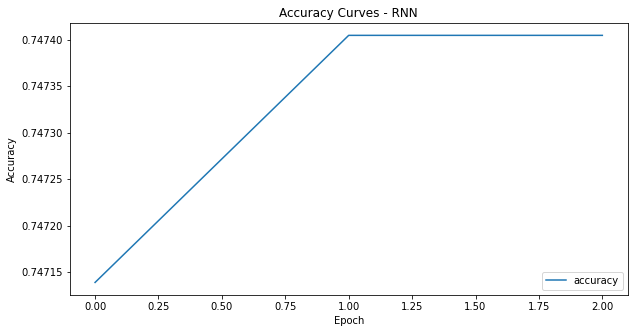

In [12]:
plt.figure(figsize=[10,5])
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curves - RNN')

In [13]:
model1 = Sequential()
model1.add(LSTM(128,  return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(32))
model1.add(Dense(2, activation='softmax'))

In [14]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
history1 = model1.fit(train_X, train_Y,epochs=3, verbose=1)

Epoch 1/3
118/118 [==============================] - 88s 745ms/step - loss: 0.5707 - accuracy: 0.7455
Epoch 2/3
118/118 [==============================] - 91s 772ms/step - loss: 0.5668 - accuracy: 0.7474
Epoch 3/3
118/118 [==============================] - 91s 772ms/step - loss: 0.5668 - accuracy: 0.7474


In [16]:
model2 = Sequential()
model2.add(LSTM(128,  return_sequences=True))
model2.add(Dropout(0.15))
model2.add(LSTM(32))
model2.add(Dense(2, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(train_X, train_Y,epochs=5, verbose=1)

Epoch 1/5
118/118 [==============================] - 88s 744ms/step - loss: 0.5718 - accuracy: 0.7458
Epoch 2/5
118/118 [==============================] - 92s 780ms/step - loss: 0.5665 - accuracy: 0.7474
Epoch 3/5
118/118 [==============================] - 93s 786ms/step - loss: 0.5663 - accuracy: 0.7474
Epoch 4/5
118/118 [==============================] - 92s 776ms/step - loss: 0.5651 - accuracy: 0.7474
Epoch 5/5
118/118 [==============================] - 92s 776ms/step - loss: 0.5628 - accuracy: 0.7474
